In [1]:
# Import libraries
import random
import os
import numpy as np 
import pandas as pd 
import requests
from dotenv import load_dotenv

# Date
import datetime as dt
from datetime import date, timedelta, datetime

# EDA
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# FE
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.inspection import permutation_importance
# import eli5
# from eli5.sklearn import PermutationImportance
import shap

# Time Series - EDA and Modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Modeling and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load environment variables from .env file
load_dotenv()

# Import environment variables
start_date = os.getenv('start_date')
end_date = os.getenv('end_date')
btc_etf_start_date = os.getenv('btc_etf_start_date')
btc_etf_end_date = os.getenv('btc_etf_end_date')

# Set main parameters
cryptocurrency = 'BTC'
target = 'ADJ_CLOSE'
forecasting_days = 10  

# 2) Load the data

In [3]:
df = pd.read_parquet(os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))), "MLCryptoPredictor\\data\\final_df_without_stationarity_test.parquet.gzip"))

## i) Data Preparation

In [4]:
df.head()

,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,GOLD_ADJ_CLOSE,SILVER_ADJ_CLOSE,OIL_ADJ_CLOSE,GOLD_VOLUME,...,BTC_PRICE_MIN_7D,BTC_PRICE_MAX_7D,BTC_PRICE_MIN_14D,BTC_PRICE_MAX_14D,BTC_PRICE_MIN_21D,BTC_PRICE_MAX_21D,BTC_PRICE_MIN_30D,BTC_PRICE_MAX_30D,BTC_PRICE_MIN_60D,BTC_PRICE_MAX_60D
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,1313.699951,17.121000,60.369999,68.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,1313.699951,17.121000,60.369999,68.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,1316.199951,17.184999,61.630001,42.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,1319.400024,17.188999,62.009998,2.0,...,0,0,0,0,0,0,0,0,0,0
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,1320.300049,17.205000,61.439999,1.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print([col for col in df.columns])

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME', 'GOLD_ADJ_CLOSE', 'SILVER_ADJ_CLOSE', 'OIL_ADJ_CLOSE', 'GOLD_VOLUME', 'SILVER_VOLUME', 'OIL_VOLUME', 'EUR_USD_ADJ_CLOSE', 'USD_JPY_ADJ_CLOSE', 'GBP_USD_ADJ_CLOSE', 'USD_CNY_ADJ_CLOSE', 'VIX_ADJ_CLOSE', 'CBOE_INTEREST_RATE_ADJ_CLOSE', 'TREASURY_YIELD_5YRS_ADJ_CLOSE', 'RUSSEL_2000_ADJ_CLOSE', 'ISHARES_20YR_ADJ_CLOSE', 'TREASURY_BILL_13WK_ADJ_CLOSE', 'RUSSEL_2000_VOLUME', 'ISHARES_20YR_VOLUME', 'TESLA_ADJ_CLOSE', 'AMD_ADJ_CLOSE', 'INTEL_ADJ_CLOSE', 'APPLE_ADJ_CLOSE', 'NVIDIA_ADJ_CLOSE', 'META_ADJ_CLOSE', 'GOOGLE_ADJ_CLOSE', 'TESLA_VOLUME', 'AMD_VOLUME', 'INTEL_VOLUME', 'APPLE_VOLUME', 'NVIDIA_VOLUME', 'META_VOLUME', 'GOOGLE_VOLUME', 'GBTC_ADJ_CLOSE', 'ARKB_ADJ_CLOSE', 'BITB_ADJ_CLOSE', 'FBTC_ADJ_CLOSE', 'BTCO_ADJ_CLOSE', 'IBIT_ADJ_CLOSE', 'HODL_ADJ_CLOSE', 'BITO_ADJ_CLOSE', 'GBTC_VOLUME', 'ARKB_VOLUME', 'BITB_VOLUME', 'FBTC_VOLUME', 'BTCO_VOLUME', 'IBIT_VOLUME', 'HODL_VOLUME', 'BITO_VOLUME', 'ETH_ADJ_CLOSE', 'ETH_VOLUME', 'USDT_ADJ_C

In [6]:
print(f"Minimum Date: {df.index.min()}", f"Maximum Date: {df.index.max()}")

Minimum Date: 2018-01-01 00:00:00 Maximum Date: 2024-03-31 00:00:00


In [7]:
has_nan = df.isna().any().any()
print(f"Are there any NaN values in the DataFrame?{has_nan}")

Are there any NaN values in the DataFrame?False


In [8]:
# Create a new dataframe with the potential target variable and the features
df_targets = df.iloc[:, -13:]
# Remove the last 13 columns from the original DataFrame
df = df.iloc[:, :-13]

In [9]:
# Calculate the split point (80% of the data)
split_point = int(len(df) * 0.8)

# Split the data
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Training data date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data date range: {test_data.index.min()} to {test_data.index.max()}")

Training data shape: (1825, 296)
Testing data shape: (457, 296)
Training data date range: 2018-01-01 00:00:00 to 2022-12-30 00:00:00
Testing data date range: 2022-12-31 00:00:00 to 2024-03-31 00:00:00


In [10]:
# Calculate the validation split point (20% of the training data)
val_split_point = int(len(train_data) * 0.9)

# Split the training data into training and validation sets
train_data_final = train_data.iloc[:val_split_point]
val_data = train_data.iloc[val_split_point:]

print(f"Final training data shape: {train_data_final.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Final training data date range: {train_data_final.index.min()} to {train_data_final.index.max()}")
print(f"Validation data date range: {val_data.index.min()} to {val_data.index.max()}")

Final training data shape: (1642, 296)
Validation data shape: (183, 296)
Final training data date range: 2018-01-01 00:00:00 to 2022-06-30 00:00:00
Validation data date range: 2022-07-01 00:00:00 to 2022-12-30 00:00:00


In [11]:
# Assuming df is your DataFrame with date index
# Split your data into features (X) and target variable (y)
X = df.drop(['ADJ_CLOSE'] + df.iloc[:, :4].columns.tolist() + [col for col in df.columns if 'OTHERS' in col], axis=1)  # Replace 'target_column_name' with your actual target column name
y = df['ADJ_CLOSE']

Training data shape: (1825, 287)
Testing data shape: (457, 287)
Training data date range: 2018-01-01 00:00:00 to 2022-12-30 00:00:00
Testing data date range: 2022-12-31 00:00:00 to 2024-03-31 00:00:00
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best cross-validation score:  0.15261391531892635


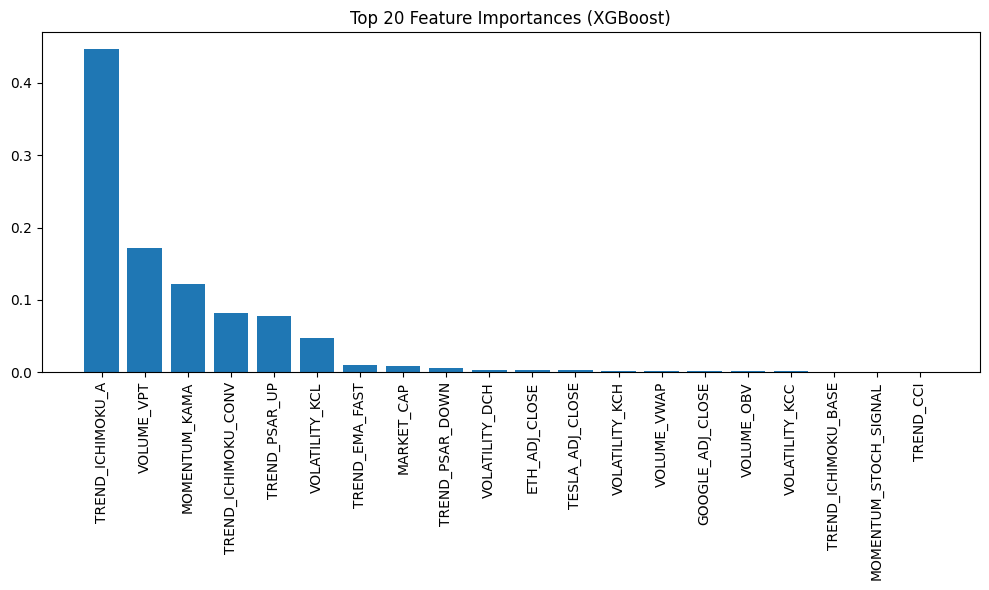

Selected features: ['VOLUME', 'GOLD_ADJ_CLOSE', 'SILVER_ADJ_CLOSE', 'OIL_ADJ_CLOSE', 'SILVER_VOLUME', 'OIL_VOLUME', 'CBOE_INTEREST_RATE_ADJ_CLOSE', 'RUSSEL_2000_ADJ_CLOSE', 'TREASURY_BILL_13WK_ADJ_CLOSE', 'RUSSEL_2000_VOLUME', 'TESLA_ADJ_CLOSE', 'AMD_ADJ_CLOSE', 'INTEL_ADJ_CLOSE', 'APPLE_ADJ_CLOSE', 'NVIDIA_ADJ_CLOSE', 'GOOGLE_ADJ_CLOSE', 'TESLA_VOLUME', 'AMD_VOLUME', 'INTEL_VOLUME', 'META_VOLUME', 'GOOGLE_VOLUME', 'ETH_ADJ_CLOSE', 'USDT_VOLUME', 'USDC_ADJ_CLOSE', 'USDC_VOLUME', 'DOGE_ADJ_CLOSE', 'XRP_ADJ_CLOSE', 'XRP_VOLUME', 'SOL_ADJ_CLOSE', 'SOL_VOLUME', 'GAS_ADJ_CLOSE', 'GAS_USD', 'GREED', 'UNRATE', 'INTEREST_RATE_ADJUSTED', 'TREASURE_MATURITY_ADJUSTED', 'M2_MONEY_STOCK_ADJUSTED', 'VOLUME_ADI', 'VOLUME_OBV', 'VOLUME_CMF', 'VOLUME_FI', 'VOLUME_EM', 'VOLUME_SMA_EM', 'VOLUME_VPT', 'VOLUME_VWAP', 'VOLUME_NVI', 'VOLATILITY_BBM', 'VOLATILITY_BBH', 'VOLATILITY_BBL', 'VOLATILITY_BBW', 'VOLATILITY_BBP', 'VOLATILITY_KCC', 'VOLATILITY_KCH', 'VOLATILITY_KCL', 'VOLATILITY_KCP', 'VOLATILITY_KCHI

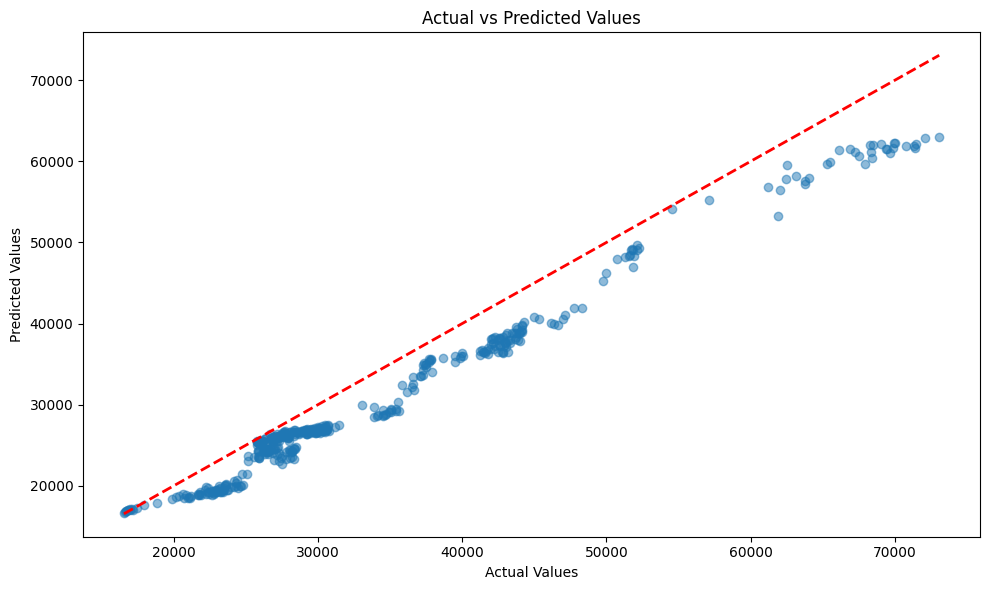

In [39]:
# Calculate the split point (80% of the data)
split_point = int(len(df) * 0.8)

# Split the data
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training data date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data date range: {X_test.index.min()} to {X_test.index.max()}")

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state = 42)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=10, cv=tscv, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Get feature importances
feature_importance = pd.DataFrame({'feature': X_train.columns, 
                                   'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=90)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# Select features based on importance threshold
selector = SelectFromModel(best_model, prefit=True, threshold='median')
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = X_train.columns[selector.get_support()].tolist()

print("Selected features:", selected_features)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.tight_layout()
plt.show()